In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_excel('saved_tracks.xlsx')

In [3]:
df.rename(columns={'Unnamed: 0':'temp'},inplace=True)
df.drop(['temp','type','uri','track_href','analysis_url','time_signature'],axis=1,inplace=True)

In [4]:
# Data Cleaning

# Change index
df.index = df['id']

# convert loudness from dB scale to intensity scale. Consider I0 = 1
df['loudness'] = 10**(df['loudness']/10)

df['added_at'] = df['added_at'].apply(lambda x : x[0:10])
df['added_month'] = df['added_at'].apply(lambda x : x[5:7])
df['added_year'] = df['added_at'].apply(lambda x : x[0:4])
df.drop(['added_at','id'],axis=1,inplace=True)

In [5]:
# Converting months and years from strings to integers, and dropped added_year

df['added_month'] = df['added_month'].apply(lambda x : int(x))
df['added_year'] = df['added_year'].apply(lambda x : int(x))
df.drop(df[df['added_year'] == 2018].index, inplace=True)

In [6]:
temp_2019 = df[df['added_year'] == 2019].copy()
temp_2020 = df[df['added_year'] == 2020].copy()
temp_2019.drop('added_year',axis=1,inplace=True)
temp_2020.drop('added_year',axis=1,inplace=True)

In [7]:
feature_list = ['danceability', 'energy', 'speechiness', 'acousticness', 'valence']
df_2019 = pd.DataFrame(0, index=range(1,13,1), columns=feature_list)
df_2020 = pd.DataFrame(0, index=range(1,13,1), columns=feature_list)
df_2019.index.names=['month']
df_2020.index.names=['month']

In [8]:
for i in range (1,13,1):
    for feature in feature_list:
        df_2019.loc[i,feature] = temp_2019[temp_2019['added_month'] == i][feature].mean()
        df_2020.loc[i,feature] = temp_2020[temp_2020['added_month'] == i][feature].mean()  

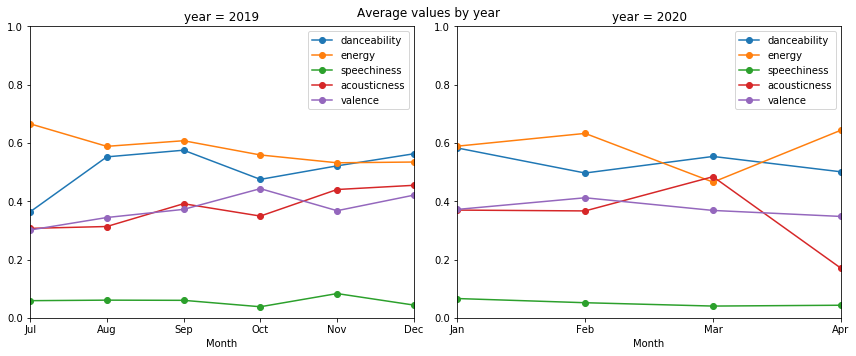

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
xticks = 'Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec'.split()
plt.setp(ax, xticks=[1,2,3,4,5,6,7,8,9,10,11,12], xticklabels=xticks)
for feature in feature_list:
    ax[0].plot(df_2019.index,df_2019[feature],marker='o')
    ax[1].plot(df_2020.index,df_2020[feature],marker='o')
ax[0].set_ylim([0, 1])    
ax[1].set_ylim([0, 1])      
ax[0].set_title('year = 2019')
ax[1].set_title('year = 2020')
ax[0].set_xlim([7, 12])
ax[1].set_xlim([1, 4])
ax[0].set_xlabel('Month')
ax[1].set_xlabel('Month')
fig.suptitle('Average values by year')
ax[0].legend(['danceability', 'energy', 'speechiness', 'acousticness', 'valence'])
ax[1].legend(['danceability', 'energy', 'speechiness', 'acousticness', 'valence'])
plt.tight_layout()
fig.savefig('Avg_val_by_year.png', dpi=600)

In [10]:
cluster_features = ['danceability', 'energy', 'speechiness', 'acousticness', 'valence']

In [11]:
# Scaling features using standard scaler before clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df[cluster_features])
scaled_features = scaler.transform(df[cluster_features])
scaled_df_cluster = pd.DataFrame(scaled_features,columns=['danceability', 'energy', 'speechiness', 'acousticness', 'valence'])

In [12]:
from sklearn.cluster import KMeans

In [13]:
# Using elbow method to find optimal K value for K-means clustering

sum_of_squared_distances = []
K = range(1,12,1)
for i in K:
    kmeans = KMeans(n_clusters=i, random_state=123)
    km = kmeans.fit(scaled_df_cluster)
    sum_of_squared_distances.append(km.inertia_)

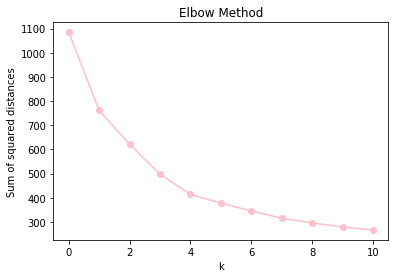

In [14]:
plt.plot(sum_of_squared_distances, marker='o',color='pink')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.savefig('Elbow_Method', dpi=600)

# n_clusters = 5 seems a good value from the graph

In [16]:
# We have our clusters, but to be able to visualise our data, we need dimensionality reduction. 
# Let us use PCA, and obtain a scree plot to get an idea of how many components we should take for PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(scaled_df_cluster)
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)

In [17]:
percent_variance

array([43.15, 25.01, 17.23,  9.87,  4.75])

In [18]:
# Clearly, the first 3 components explain (43.15 + 25.01 + 17.23) ~ 85.39% of the variance, which means a 3D visualisation can be done
# Although points from different clusters will be somewhat intermixed.

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(scaled_df_cluster)

In [19]:
principalComponentDataframe = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])

In [20]:
principalComponentDataframe

,PC1,PC2,PC3
0,0.168501,-1.730516,-0.552652
1,-0.757776,-1.189126,-0.547075
2,-0.283687,-0.562049,-0.527699
3,0.276343,1.723539,-0.189678
4,-0.807328,-1.459652,-0.470129
...,...,...,...
212,1.954568,0.071544,0.363300
213,1.530879,-0.988465,-0.125038
214,-0.787489,-0.907552,-0.698769
215,-0.496724,-2.438942,0.825296


In [21]:
kmeans = KMeans(n_clusters=5, random_state=123)
km = kmeans.fit(scaled_df_cluster)
sum_of_squared_distances.append(km.inertia_)
scaled_df_cluster['labels'] = km.labels_

In [22]:
final_df = pd.concat([principalComponentDataframe, scaled_df_cluster['labels']],axis = 1)

In [56]:
final_df

,PC1,PC2,PC3,labels
0,0.168501,-1.730516,-0.552652,2
1,-0.757776,-1.189126,-0.547075,2
2,-0.283687,-0.562049,-0.527699,2
3,0.276343,1.723539,-0.189678,1
4,-0.807328,-1.459652,-0.470129,2
...,...,...,...,...
212,1.954568,0.071544,0.363300,3
213,1.530879,-0.988465,-0.125038,3
214,-0.787489,-0.907552,-0.698769,2
215,-0.496724,-2.438942,0.825296,2


In [95]:
temp_df = df[['danceability', 'energy', 'speechiness', 'acousticness', 'valence', 'song_title', 'artists']].copy()
temp_df = temp_df.reset_index()
temp_df.drop('id',axis=1,inplace=True)
temp_df = pd.concat([temp_df, final_df], axis=1)
temp_df['song'] = temp_df['song_title']+ ' - ' +temp_df['artists']
temp_df.drop(['song_title', 'artists'],axis=1,inplace=True)

In [97]:
import plotly.express as px
fig = px.scatter_3d(temp_df, x='PC1', y='PC2', z='PC3', color='labels', opacity=0.8, hover_name='song', hover_data=['danceability', 'energy', 'speechiness', 'acousticness', 'valence'])
fig.show()

fig.write_html('clusters.html')

In [282]:
temp = df[['danceability', 'energy', 'speechiness', 'acousticness', 'valence']].copy()
temp['labels'] = km.labels_

In [283]:
df_0 = (temp[temp['labels'] == 0]).copy()
df_1 = (temp[temp['labels'] == 1]).copy()
df_2 = (temp[temp['labels'] == 2]).copy()
df_3 = (temp[temp['labels'] == 3]).copy()
df_4 = (temp[temp['labels'] == 4]).copy()

df_0.drop('labels',axis=1,inplace=True)
df_1.drop('labels',axis=1,inplace=True)
df_2.drop('labels',axis=1,inplace=True)
df_3.drop('labels',axis=1,inplace=True)
df_4.drop('labels',axis=1,inplace=True)

In [284]:
df_final_final = pd.DataFrame(0, index=range(1,5,1), columns=feature_list)

In [285]:
for i in range (0,5,1):
    for feature in feature_list:
        if (i==0):
            df_final_final.loc[i,feature] =  df_0[feature].mean()
        elif (i==1):
            df_final_final.loc[i,feature] =  df_1[feature].mean()
        elif (i==2):
            df_final_final.loc[i,feature] =  df_2[feature].mean()
        elif (i==3):
            df_final_final.loc[i,feature] =  df_3[feature].mean()
        elif (i==4):
            df_final_final.loc[i,feature] =  df_4[feature].mean()

In [286]:
df_final_final = df_final_final.sort_index()

In [292]:
df_final_final

,danceability,energy,speechiness,acousticness,valence
0,0.649200,0.759244,0.077142,0.192344,0.634289
1,0.655289,0.456444,0.039991,0.661622,0.429156
2,0.475400,0.689429,0.048786,0.123654,0.297776
3,0.399802,0.318081,0.036298,0.727362,0.204400
4,0.617800,0.631000,0.278700,0.300751,0.384400


In [303]:
categories = df_final_final.keys().to_numpy()
r0 = df_final_final.iloc[0].copy().to_numpy()
r1 = df_final_final.iloc[1].copy().to_numpy()
r2 = df_final_final.iloc[2].copy().to_numpy()
r3 = df_final_final.iloc[3].copy().to_numpy()
r4 = df_final_final.iloc[4].copy().to_numpy()

r0 = np.append(r0,r0[0])
r1 = np.append(r1,r1[0])
r2 = np.append(r2,r2[0])
r3 = np.append(r3,r3[0])
r4 = np.append(r4,r4[0])

In [343]:
angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]
angles = np.append(angles,angles[0])
delta = np.pi/2 - angles[1]
for i in range(len(angles)):
    angles[i] += delta

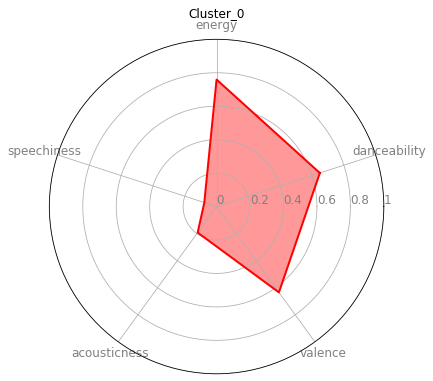

In [365]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), subplot_kw=dict(polar=True))

ax.plot(angles, r0, linewidth=2, linestyle='solid', color='red')
ax.fill(angles, r0, 'red', alpha=0.4)
plt.xticks(angles[:-1], categories, color='grey', size=12)
plt.yticks(np.arange(0,1.2,0.2), ['0', '0.2', '0.4', '0.6', '0.8', '1'],
           color='grey', size=12)
plt.ylim(0, 1)
ax.set_rlabel_position(0)
plt.tight_layout()
plt.title('Cluster_0')
plt.savefig('Cluster_0.png')